In [1]:
from Py6S import *
import numpy as np
%matplotlib widget
import ipywidgets as widgets
from matplotlib import pyplot as plt

In [2]:
def wattsToPhotons(radwatts,waves):
    return radwatts/(1.98644582e-25/(waves*1e-6))

def convertRadAtSatLevelToPhotonsCapturedBySensor(radwatts, waves, apeture, efl, pixelsize, int_time, dlam, QE, inst_trans):
    phots=wattsToPhotons(radwatts,waves)
    
    fnum=efl/apeture
    A=pixelsize**2
    SLDangle=apeture**2 * np.pi / (4*efl**2)
    
    captured_phots = phots * int_time * A * SLDangle * dlam * inst_trans * QE
    
    return captured_phots

In [3]:
s = SixS()
#s.atmos_profile = AtmosProfile.PredefinedType(AtmosProfile.Tropical)

s.altitudes.set_sensor_satellite_level()
s.atmos_profile = AtmosProfile.PredefinedType(AtmosProfile.Tropical)
#s.ground_reflectance = GroundReflectance.HomogeneousLambertian(GroundReflectance.GreenVegetation)
s.geometry = Geometry.User()
s.geometry.from_time_and_location(-35.0481, 150.7447, "06:00:00", 0, 0) #% 11am AEDT

wv, res = SixSHelpers.Wavelengths.run_wavelengths(s,np.arange(0.400, 1, 0.01), output_name='pixel_radiance')

Running for many wavelengths - this may take a long time


In [36]:
# set up plot
fig, ax = plt.subplots(figsize=(6, 4))

ax.grid(True)
ax.autoscale(True, 'both', True)


captured_phots= convertRadAtSatLevelToPhotonsCapturedBySensor(radwatts=res,
                                                              waves=wv, 
                                                              apeture=45e-3, 
                                                              efl=700*1e-3, 
                                                              pixelsize=5.5e-6, 
                                                              int_time=2e-3,
                                                              dlam=0.015, 
                                                              QE=0.7, 
                                                              inst_trans=0.8)
 
@widgets.interact(apeture=(10, 100, 1), efl=(100, 1000, 20), pixelsize=(5.5, 50.5, 1),int_time=(1,10,1),dlam=(1,50,1))
def update(apeture = 45, efl=700, pixelsize=5.5, int_time=2,dlam=15):
    """Remove old lines from plot and plot new one"""
    [l.remove() for l in ax.lines]
    
    SN=np.sqrt(convertRadAtSatLevelToPhotonsCapturedBySensor(radwatts=res,
                                                              waves=wv, 
                                                              apeture=apeture*1e-3, 
                                                              efl=efl*1e-3, 
                                                              pixelsize=pixelsize*1e-6, 
                                                              int_time=int_time*1e-3,
                                                              dlam=dlam*1e-3, 
                                                              QE=0.7, 
                                                              inst_trans=0.8))
    ax.set_title("Mean S/N: {:.2f}".format(np.nanmean(SN)))
    #ax.set_ylim([0, np.nanmax(SN)*1.1])
    ax.plot(wv, SN, color='C0')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

interactive(children=(IntSlider(value=45, description='apeture', min=10), IntSlider(value=700, description='ef…

In [4]:
captured_phots= convertRadAtSatLevelToPhotonsCapturedBySensor(radwatts=res,
                                                              waves=wv, 
                                                              apeture=45e-3, 
                                                              efl=700*1e-3, 
                                                              pixelsize=5.5e-6, 
                                                              int_time=2e-3,
                                                              dlam=0.015, 
                                                              QE=0.7, 
                                                              inst_trans=0.8)

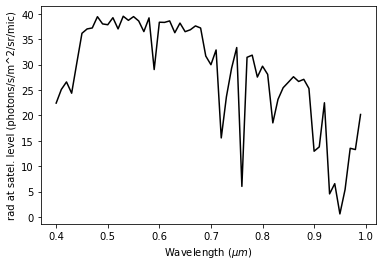

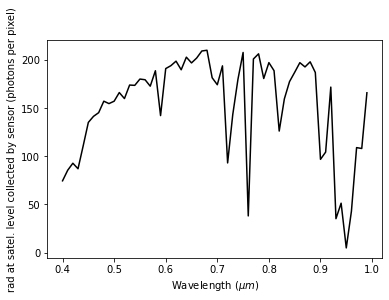

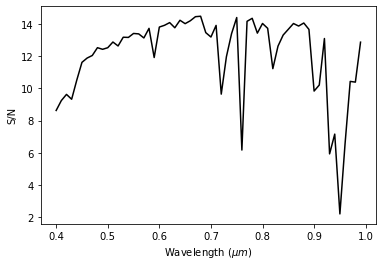

In [5]:
%matplotlib inline
SixSHelpers.Wavelengths.plot_wavelengths(wv, res, "rad at satel. level (photons/s/m^2/sr/mic)")
SixSHelpers.Wavelengths.plot_wavelengths(wv, captured_phots, "rad at satel. level collected by sensor (photons per pixel)")
SixSHelpers.Wavelengths.plot_wavelengths(wv, captured_phots/np.sqrt(captured_phots), "S/N")

In [6]:
loopfnum=[]
loopgsd=[]
loopsn=[]
for loopefl in range(50, 800, 10):
    apeture=45e-3
    pixelsize=5.5e-6
    efl=loopefl*1e-3
    
    fnum=efl/apeture
    
    captured_phots= convertRadAtSatLevelToPhotonsCapturedBySensor(radwatts=res,
                                                                  waves=wv, 
                                                                  apeture=40e-3, 
                                                                  efl=loopefl*1e-3, 
                                                                  pixelsize=pixelsize, 
                                                                  int_time=2e-3,
                                                                  dlam=0.015, 
                                                                  QE=0.7, 
                                                                  inst_trans=0.8)

    loopfnum.append(fnum)
    loopgsd.append(550e3/efl *2 *pixelsize)
    loopsn.append(np.nanmean(np.sqrt(captured_phots)))
    
#         print("F/#: {}".format(fnum))
#         print("Resolution Element Size: {} m, for EFL: {} mm".format(550e3/efl *2 *pixelsize,efl*1e3))
#         print("Mean S/N: {}".format(np.nanmean(np.sqrt(captured_phots))))

In [7]:
%matplotlib widget
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('F/#')
ax1.set_ylabel('S/N', color=color)
ax1.plot(loopfnum, loopsn, color=color)
ax1.tick_params(axis='y', labelcolor=color)
plt.grid(True)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('GSD (m)', color=color)  # we already handled the x-label with ax1
ax2.plot(loopfnum, loopgsd, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …